# KMeans Algorithm GPU batched implementation using Pytorch

In [1]:
import math, matplotlib.pyplot as plt, operator, torch
from functools import partial
torch.manual_seed(42)
torch.set_printoptions(precision=3, linewidth=140, sci_mode=False)
from torch.distributions.multivariate_normal import MultivariateNormal
from torch import tensor

We're going to pick 6 random points, which we'll call centroids, and for each point we're going to generate 250 random points about it.

In [2]:
n_clusters=6
n_samples =250

centroids = torch.rand(n_clusters, 2)*70-35
centroids


tensor([[ 26.759,  29.050],
        [ -8.200,  32.151],
        [ -7.669,   7.063],
        [-17.040,  20.555],
        [ 30.854, -25.677],
        [ 30.422,   6.551]])

In [3]:
def sample(m): return MultivariateNormal(m, torch.diag(tensor([5.,5.]))).sample((n_samples,))
slices = [sample(c) for c in centroids]
data = torch.cat(slices)
data.shape
data.to('cuda')

tensor([[26.204, 26.349],
        [25.691, 30.213],
        [30.431, 28.693],
        ...,
        [30.772,  9.323],
        [29.354,  3.960],
        [31.168,  5.309]], device='cuda:0')

We're going to create a 1D tensor, which will store information about which cluster does the particular data point on that index belongs to 

In [4]:
#1 select K, initialize assignment
K = 6
assignment = torch.zeros(data.shape[0])
assignment.to('cuda')
assignment = assignment.long()



Now, we will define the batch size and perform their clustering updates on batch of points per iteration on the GPU 

In [5]:
centroids = data[:K, :].clone()
centroids.to('cuda')

tensor([[26.204, 26.349],
        [25.691, 30.213],
        [30.431, 28.693],
        [25.647, 30.033],
        [31.236, 30.093],
        [30.276, 26.987]], device='cuda:0')

In [6]:

# aassignment.long()
print(assignment.dtype)

torch.int64


In [7]:
n = len(data)
print(n)
bs = 6
for i in range(0,n,bs):
        s = slice(i, min(i+bs,n))
        assignment[s] = ((data[s][:,None] - centroids[None])**2).sum(2).sqrt().argmin(dim=1).long().view(-1)
        centroids.scatter_add_(0,assignment[:,None].repeat(1,2),data)
        NCs =  torch.bincount(assignment, minlength=K).type_as(centroids).view(K,1)
        centroids /= NCs
        # print(f"{i} th iteration centroid and assignment", centroids,assignment)


1500


In [9]:
centroids

tensor([[   9.163,   11.553],
        [6448.389, 7583.556],
        [7638.220, 7202.036],
        [6437.297, 7538.334],
        [7840.320, 7553.408],
        [7599.360, 6773.688]])

Now let's write a function to plot these data points and see the trends of the clustering

In [10]:
def plot_data_kmeans(centroids, data, assignment, ax=None):
    if ax is None: _,ax = plt.subplots()
    for i, centroid in enumerate(centroids):
        samples = data[assignment==i]
        ax.scatter(samples[:,0], samples[:,1], s=1)
        ax.plot(*centroid, markersize=10, marker="x", color='k', mew=5)
        ax.plot(*centroid, markersize=5, marker="x", color='m', mew=2)

Let's put all this in one single function and see how it performs

In [33]:
def kmeans_gpu(data,Cs=None,assignment=None,bs=100,K=6,iteration=10):
    
    n = len(data)
    Cs = data[torch.randint(0, len(data), (K,))]
        
    # if assignment is None: 
    assignment = torch.zeros(data.shape[0])
    assignment = assignment.to('cuda')
    assignment = assignment.long()
    
    for it in range(iteration):
        for i in range(0,n,bs):
            s = slice(i, min(i+bs,n))
            assignment[s] = ((data[s][:,None] - Cs[None])**2).sum(2).sqrt().argmin(dim=1).long().view(-1)
            Cs.zero_()
            Cs.scatter_add_(0,assignment[:,None].repeat(1,2),data)
            NCs =  torch.bincount(assignment, minlength=K).type_as(Cs).view(K,1)
            Cs /= NCs
    return Cs, assignment.detach().cpu()

In [34]:
def test_gpu(data,iteration):
    X = data.clone().to('cuda')
    Cs,ass = kmeans_gpu(data=X,iteration=5)
    return X.detach().cpu(),ass.detach().cpu(), Cs.detach().cpu()

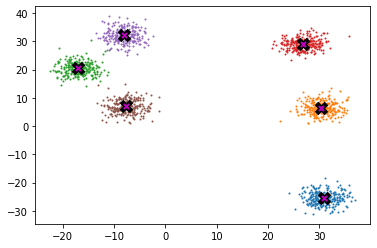

In [35]:
test = test_gpu(data,iteration=10)
plot_data_kmeans(test[2], test[0],test[1] )

In [36]:
%timeit -n 10 test_gpu(data,iteration=10)

34.3 ms ± 2.11 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
